In [1]:
import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(0) # Seed 고정

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def mae(y, pred):
    return np.mean(abs(y-pred))
 #점수 측정을 위한 코드  
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def validate(valid_x, valid_y, model):
    pred = model.predict(valid_x)
    smape_score, mae_score = SMAPE(valid_y, pred), mae(valid_y, pred)
    return smape_score, mae_score

In [2]:
clusters = [
[3, 32, 61, 62, 63, 64, 65, 66, 67, 68],
[8, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 58, 59, 60, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84],
[1, 2, 4, 5, 6, 7, 9, 11, 12, 16, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 54, 57, 81, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
[10, 13, 14, 15]
]

drop_cols = [
    [ 'week', 'THI', 'CDH', 'max_power', 'min_power','day_hour_mean','day_hour_std', 'hour_mean', 'hour_std','outlier','sensory','Rain_cat'],
    [ 'week', 'THI', 'CDH', 'max_power', 'min_power' ,'day_hour_mean','day_hour_std','hour_mean', 'hour_std','sensory','Rain_cat'],
    [ 'week', 'THI', 'CDH', 'max_power', 'min_power' ],
    [ 'week','month','holiday', 'THI', 'CDH', 'day_hour_mean', 'day_hour_std',
       'hour_mean', 'hour_std', 'max_power', 'min_power', 'THI_cat', 'sensory','Rain_cat']
    ]

for n_estimator in [40,45,50,55]:
    smape_scores = []
    mae_scores = []
    for k in range(4):
        cluster = clusters[k]
        drop_col = drop_cols[k]

        for i in tqdm(cluster):
            train_df = pd.read_csv(f'./pretest/train_building{i}.csv').drop(columns=drop_col)
            pretest_df = pd.read_csv(f'./pretest/pretest_building{i}.csv').drop(columns=drop_col)
            x_train = train_df.drop(columns=['power_consumption'])
            y_train = train_df['power_consumption']
            y_valid = pretest_df['power_consumption']
            x_valid = pretest_df.drop(columns=['power_consumption'])
            
            #print(f"building_{i}")
            model_lgb1 = lgb.LGBMRegressor(objective='regression',
                                        n_estimators= n_estimator,
                                        verbose=-1)
            model_lgb1.fit(x_train, y_train)
            smape_score, mae_score = validate(x_valid, y_valid, model_lgb1)
            smape_scores.append(smape_score)
            mae_scores.append(mae_score)
    smape_mean = np.mean(smape_scores)
    mae_mean = np.mean(mae_scores)
        
    print(f"n_estimator: {n_estimator}")
    print(f'SMAPE: {smape_mean}\nMAE: {mae_mean}')

  0%|          | 0/10 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\poum\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\envs\poum\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\poum\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\poum\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\envs\poum\Lib\subprocess.py", line 

n_estimator: 40
SMAPE: 5.549891192201342
MAE: 107.2900635291522


100%|██████████| 4/4 [00:00<00:00, 23.13it/s]


n_estimator: 45
SMAPE: 5.530365359316765
MAE: 107.31326629234789


100%|██████████| 4/4 [00:00<00:00, 24.32it/s]


n_estimator: 50
SMAPE: 5.53800568386771
MAE: 107.60976522267136


100%|██████████| 4/4 [00:00<00:00, 21.01it/s]

n_estimator: 55
SMAPE: 5.5535415981104155
MAE: 108.02601142471167


n_estimators= 45 최적

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


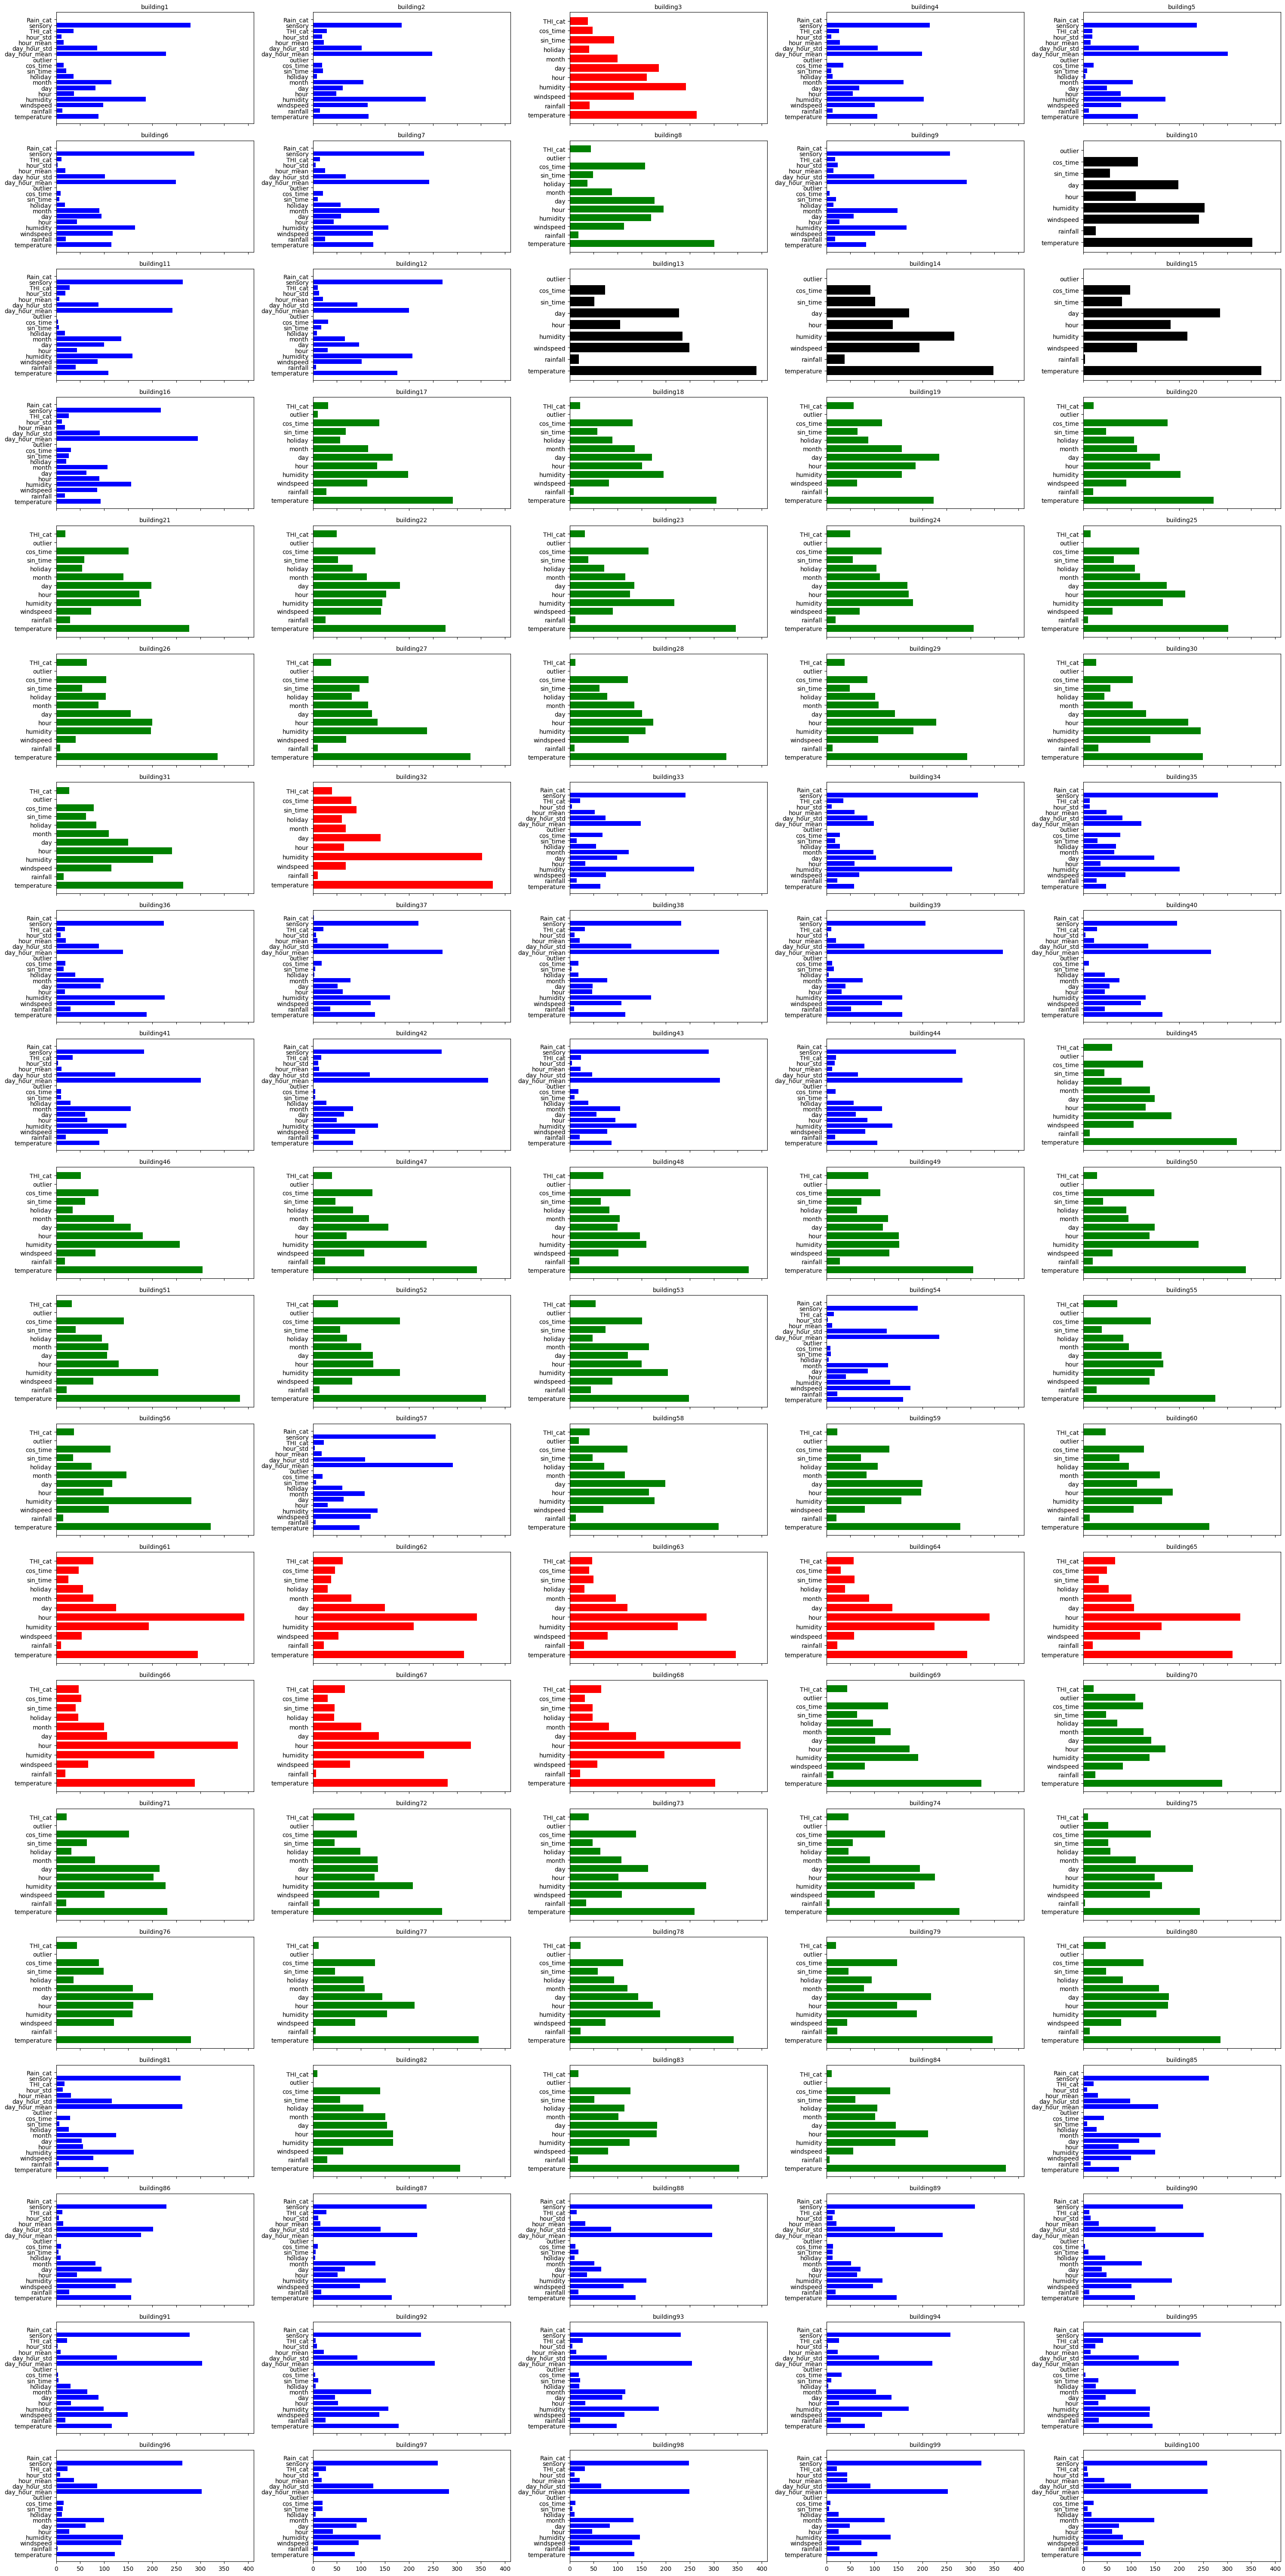

In [3]:
fig, ax = plt.subplots(20, 5, figsize=(30, 60), sharex=True)
ax = ax.flatten()
color = ['red', 'green' , 'blue', 'black']

preds = [0 for _ in range(100)]

for k in range(4):
    cluster = clusters[k]
    drop_col = drop_cols[k]
    c = color[k]
    for i in tqdm(cluster):
        feature_importances = []
        
        train_df = pd.read_csv(f'./submit/train_building{i}.csv').drop(columns=drop_col)
        test_df = pd.read_csv(f'./submit/test_building{i}.csv').drop(columns=drop_col)
        pred_df = pd.DataFrame()   # 시드별 예측값을 담을 data frame
        
        t_x = train_df.drop(columns=['power_consumption'])
        t_y = train_df['power_consumption']
    
        #print(f"building_{i}")
        for seed in [0,1,2,3,4,5,6]:
            
            model = lgb.LGBMRegressor(objective='regression',
                                        n_estimators= 45,
                                        verbose=-1,seed = seed)
            model.fit(t_x, t_y)
            y_pred = model.predict(test_df)
            feature_importances.append(model.feature_importances_)
            pred_df.loc[:,seed] = y_pred  
        pred = pred_df.mean(axis=1)
        preds[i-1] = pred
        #preds = np.append(preds, pred)
        average_feature_importances = np.mean(feature_importances, axis=0)
        ax[i-1].set_title(f'building{i}',fontsize = 10)
        ax[i-1].barh(t_x.columns, average_feature_importances, color=c)
    
    
np_preds = np.array(preds)
submit = np_preds.flatten()
plt.tight_layout()
plt.show()
    


In [4]:
########################################
csv_name = './submission/lightGBM_wsw_clust.csv'
########################################

In [6]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['answer'] = submit
submission.to_csv(f'{csv_name}', index = False)